Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from skimage import io
import glob



In [2]:
import shutil

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r'Train')
data_dir_test = pathlib.Path(r'Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='training',
    seed=123,
    shuffle=True
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='validation',
    seed=123,
    shuffle=True
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [10]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    #f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

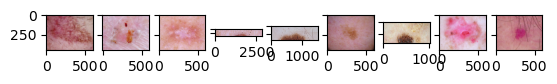

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

images=[]
### your code goes here, you can use training or validation data to visualize
for classname in class_names :
  dataset_path=os.path.join(data_dir_train, classname, '*')
  class_path = glob.glob(dataset_path)
  image = io.imread(class_path[0])
  images.append(image)

plot_image(images)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
#### Normalizing datasets
normalization_layer = layers.Rescaling(1./255)

# Apply normalization
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
### Your code goes here
model = Sequential([
    
    # Input normalization
    layers.InputLayer(shape=(img_height, img_width, 3)),
    #layers.Rescaling(1./255),

    # Convolutional layers
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and add dense layers
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 output classes
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       2,073,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             297 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,079,017 (7.93 MB)

 Trainable params: 2,079,017 (7.93 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       2,073,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             297 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,079,017 (7.93 MB)

 Trainable params: 2,079,017 (7.93 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - accuracy: 0.2044 - loss: 2.5549 - val_accuracy: 0.1924 - val_loss: 2.0696
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.2089 - loss: 2.0332 - val_accuracy: 0.2081 - val_loss: 2.0307
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.2313 - loss: 2.0254 - val_accuracy: 0.2215 - val_loss: 2.0077
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.2105 - loss: 2.0119 - val_accuracy: 0.2349 - val_loss: 2.0077
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.2752 - loss: 1.8856 - val_accuracy: 0.3356 - val_loss: 1.8618
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.3791 - loss: 1.7423 - val_accuracy: 0.4251 - val_loss: 1.7162
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.4499 - loss: 1.5888 - val_accuracy: 0.4832 - val_loss: 1.6246
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.5144 - loss: 1.4903 - val_accu

### Visualizing training results

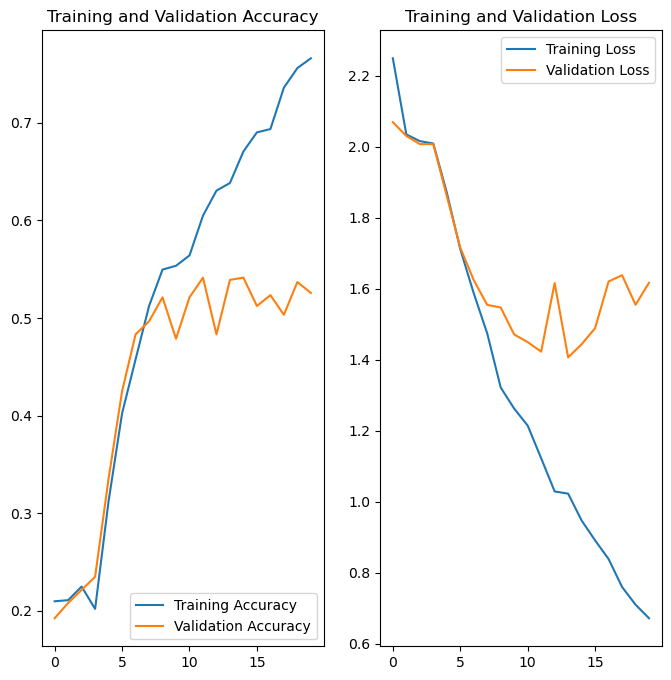

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

## After considering the accuracy and loss and learning the outputs of the epochs, it seems that the model is underfitting based on the low training and validation accuracy and high validation loss

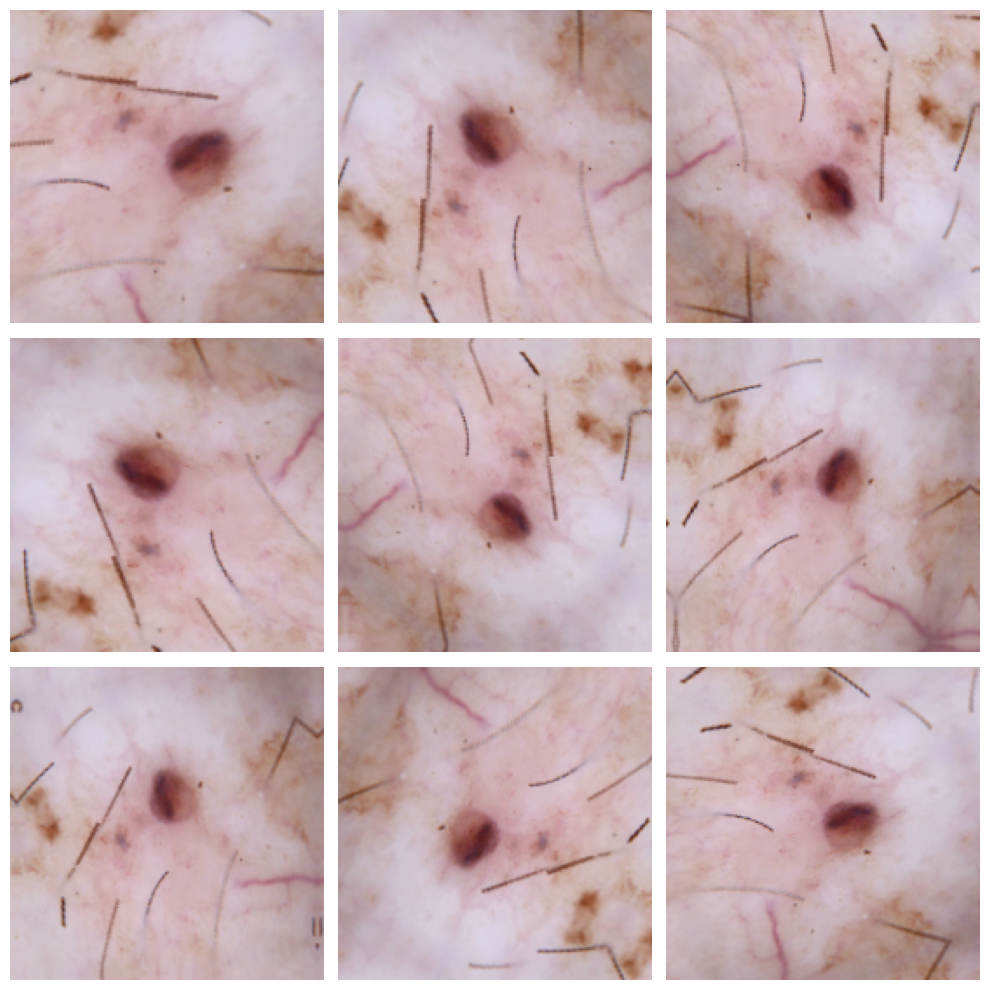

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load an image from a local file
image_path = "Train\\basal cell carcinoma\\ISIC_0031140.jpg"
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(180, 180))
image = tf.keras.preprocessing.image.img_to_array(image)

# Add batch dimension (required for augmentation layers)
image = tf.expand_dims(image, axis=0)

# Define a data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip the image
    layers.RandomRotation(0.2),                   # Randomly rotate the image
    layers.RandomZoom(0.2),                       # Randomly zoom the image
    layers.RandomContrast(0.2)                    # Randomly adjust contrast
])

# Apply augmentation multiple times to visualize different outputs
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image, training=True)
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model with dropout


In [21]:
model = Sequential([
    
    # Input normalization
    layers.InputLayer(shape=(img_height, img_width, 3)),
    #layers.Rescaling(1./255),
    data_augmentation,

    # Convolutional layers
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten and add dense layers
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 output classes
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │       2,073,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │             297 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,079,017 (7.93 MB)

 Trainable params: 2,079,017 (7.93 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 298ms/step - accuracy: 0.1746 - loss: 2.3119 - val_accuracy: 0.2170 - val_loss: 2.0303
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 345ms/step - accuracy: 0.2264 - loss: 2.0152 - val_accuracy: 0.2595 - val_loss: 1.9314
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 353ms/step - accuracy: 0.2783 - loss: 1.8904 - val_accuracy: 0.3177 - val_loss: 1.8408
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 398ms/step - accuracy: 0.3382 - loss: 1.8225 - val_accuracy: 0.3602 - val_loss: 1.7655
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - accuracy: 0.3480 - loss: 1.8260 - val_accuracy: 0.3960 - val_loss: 1.7909
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.3596 - loss: 1.7330 - val_accuracy: 0.4273 - val_loss: 1.7224
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.3890 - loss: 1.7301 - val_accuracy: 0.4161 - val_loss: 1.6825
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - accuracy: 0.3834 - loss: 1.7069 - val_accu

### Visualizing the results

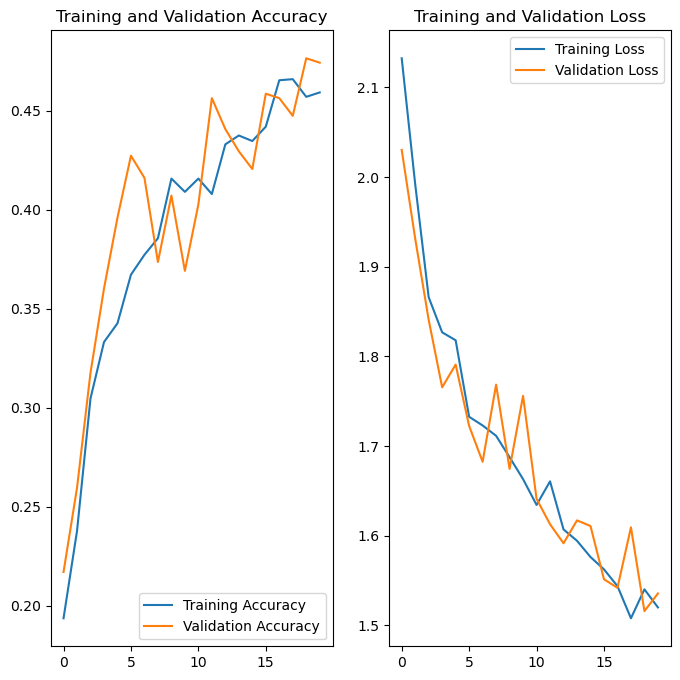

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5143 - loss: 1.4889
Validation Accuracy: 0.4743
Validation loss: 1.5356


In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

## After considering the accuracy and loss and learning the outputs of the epochs, it seems that even with dropout = 0.5 and data augmentation, the model is still underfitting based on the low training and validation accuracy and high validation loss. However the curves are better and shows a better trend.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
for classname in class_names :
    dataset_path=os.path.join(data_dir_train, classname, '*')
    class_path = glob.glob(dataset_path)
    print(classname,' : ',len(class_path))

actinic keratosis  :  114
basal cell carcinoma  :  376
dermatofibroma  :  95
melanoma  :  438
nevus  :  357
pigmented benign keratosis  :  462
seborrheic keratosis  :  77
squamous cell carcinoma  :  181
vascular lesion  :  139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 
#### - Which classes dominate the data in terms proportionate number of samples?


## Class having the least number of samples : seborrheic keratosis
## Classes dominating the data in terms  of proportionate number of samples : pigmented benign keratosis
## There is Class imbalance which needs to be rectified

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset,i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B5DF1FEB50>: 100%|█| 500/500 [00:14<00:00, 35.41 Samples/


Initialised with 376 image(s) found.
Output directory set to Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B5DA9276D0>: 100%|█| 500/500 [01:11<00:00,  6.96 Samples/


Initialised with 95 image(s) found.
Output directory set to Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B5DD622450>: 100%|█| 500/500 [00:33<00:00, 14.82 Samples/


Initialised with 438 image(s) found.
Output directory set to Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=964x720 at 0x1B5DC6C7690>: 100%|█| 500/500 [01:03<00:00,  7.81 Samples/


Initialised with 357 image(s) found.
Output directory set to Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B5DD65B890>: 100%|█| 500/500 [00:50<00:00,  9.88 Samples/


Initialised with 462 image(s) found.
Output directory set to Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B5DBBFC9D0>: 100%|█| 500/500 [00:12<00:00, 39.25 Samples/


Initialised with 77 image(s) found.
Output directory set to Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B5DF40AA50>: 100%|█| 500/500 [00:27<00:00, 17.86 Samples


Initialised with 181 image(s) found.
Output directory set to Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B5DD690150>: 100%|█| 500/500 [00:12<00:00, 39.94 Samples/


Initialised with 139 image(s) found.
Output directory set to Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B5DBCB31D0>: 100%|█| 500/500 [00:12<00:00, 40.58 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
#path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [31]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [32]:
len(dataframe_dict_new.items())

4500

In [33]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*','*.jpg'))]
len(lesion_list)

2239

In [34]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [35]:
dataframe_dict_original = dict(zip(path_list,lesion_list))

In [36]:
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df =pd.concat([original_df, df2])

In [38]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [39]:
for classname in class_names :
    dataset_path=os.path.join(data_dir_train, classname,'output', '*')
    class_path = glob.glob(dataset_path)
    print(classname,' : ',len(class_path))

actinic keratosis  :  500
basal cell carcinoma  :  500
dermatofibroma  :  500
melanoma  :  500
nevus  :  500
pigmented benign keratosis  :  500
seborrheic keratosis  :  500
squamous cell carcinoma  :  500
vascular lesion  :  500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
for classname in class_names :
    source_dir=os.path.join(data_dir_train, classname,'output')
    destination_dir=os.path.join(data_dir_train, classname)
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            shutil.move(os.path.join(root, file), destination_dir)


In [42]:
for classname in class_names :
    shutil.rmtree(os.path.join(data_dir_train, classname,'output'))

In [43]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='training',
    seed=123,
    shuffle=True
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='validation',
    seed=123,
    shuffle=True
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [46]:
## your code goes here
model = Sequential([
    # Data augmentation layer
    #data_augmentation,
    
    # Input normalization
    layers.InputLayer(input_shape=(180, 180, 3)),
    layers.Rescaling(1./255),

    # Convolutional layers
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
      
    # Flatten and add dense layers
    layers.Flatten(),
    
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 output classes
])

model.summary()

C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │       2,073,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │             297 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,079,017 (7.93 MB)

 Trainable params: 2,079,017 (7.93 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [47]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [48]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 201ms/step - accuracy: 0.1592 - loss: 2.2140 - val_accuracy: 0.3705 - val_loss: 1.6958
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step - accuracy: 0.3735 - loss: 1.6619 - val_accuracy: 0.4425 - val_loss: 1.4285
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step - accuracy: 0.4727 - loss: 1.3751 - val_accuracy: 0.5330 - val_loss: 1.2476
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 182ms/step - accuracy: 0.5257 - loss: 1.2656 - val_accuracy: 0.5642 - val_loss: 1.2107
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 181ms/step - accuracy: 0.5841 - loss: 1.1658 - val_accuracy: 0.5969 - val_loss: 1.0983
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.6366 - loss: 1.0000 - val_accuracy: 0.6132 - val_loss: 1.0458
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 183ms/step - accuracy: 0.6736 - loss: 0.9072 - val_accuracy: 0.6533 - val_loss: 0.9639
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 184ms/step - accuracy: 0.7076 - loss: 0

#### **Todo:**  Visualize the model results

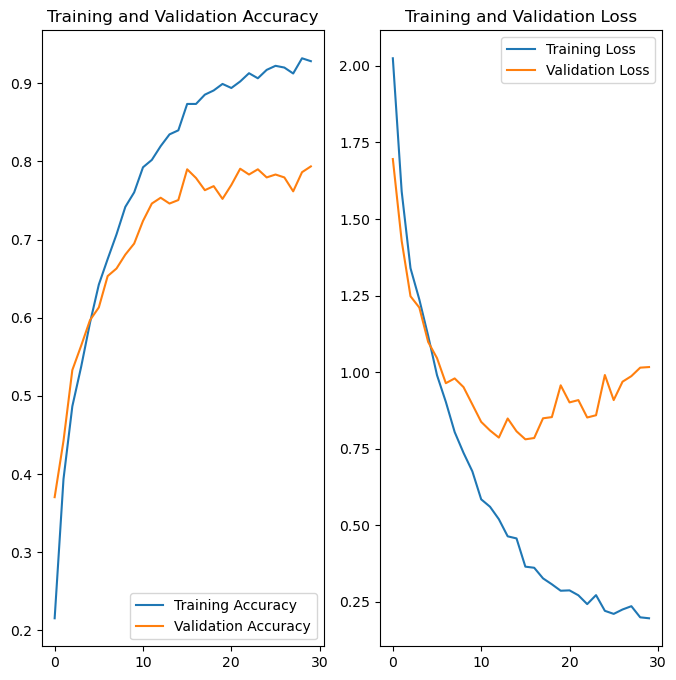

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Based on the above details we see that after rebalancing the dataset, the accuracy of training and validation has improved. It has solved the problem of underfitting to a great extent.